# k-NN (k-Nearest Neighbors) – Classification and Regression

## 1. Key Concepts

- **Core Idea**: For a new observation $x^*$, find the **k** closest training points (according to a distance metric) and:
  - **Classification**: Predict the **majority class** among the neighbors.
  - **Regression**: Predict the **average (or weighted average)** of the neighbors' target values.
- **No Explicit Training**: k-NN is a **lazy learning** algorithm because it doesn't learn a model from the training data. Instead, it memorizes the dataset, and all the work happens during inference (prediction).
- **The Choice of k**:
  - **Small k**: Low bias, high variance (the decision boundary is jagged, leading to a risk of overfitting).
  - **Large k**: High bias, low variance (the boundary is smoother, leading to a risk of underfitting).
- **Distance Metrics** (Minkowski):
  - **Euclidean ($p=2$)**: $$||\mathbf{x}-\mathbf{z}||_2 = \sqrt{\sum_{i=1}^{n}(x_i - z_i)^2}$$
  - **Manhattan ($p=1$)**: $$||\mathbf{x}-\mathbf{z}||_1 = \sum_{i=1}^{n}|x_i - z_i|$$
- **Weights**: `weights='uniform'` (all neighbors are counted equally) or `weights='distance'` (closer neighbors have more influence).
- **Feature Scaling**: This is crucial. Features with large scales will **dominate** the distance calculation if not scaled.
- **Efficiency**: The algorithm parameter can be `{'auto', 'kd_tree', 'ball_tree', 'brute'}`. KD-Tree and Ball-Tree can speed up computation, but their effectiveness degrades in high-dimensional spaces due to the *curse of dimensionality*.

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

## 2. Why Scaling is Crucial for k-NN

Let's create a dataset with **two features** on very different scales to demonstrate the performance difference **with** and **without** using `StandardScaler`.

In [2]:
# Set a random seed for reproducibility
rng = np.random.RandomState(42)

# Total number of samples
n = 600

# --- Create the synthetic dataset ---
# Feature 1: Normal distribution with mean 0 and std dev 1 (small scale)
x1 = rng.normal(loc=0.0, scale=1.0, size=(n, 1))

# Feature 2: Normal distribution with mean 0 but std dev 100 (very large scale)
x2 = rng.normal(loc=0.0, scale=100.0, size=(n, 1))

# Combine the two features into a single (n, 2) matrix X
X = np.hstack([x1, x2])

# --- Create the target variable y ---
# The class primarily depends on x1 (the first feature) plus some noise
# If x1 + noise > 0 -> class 1, otherwise class 0
y = (x1[:, 0] + 0.5 * rng.normal(size=n) > 0).astype(int)

# --- Split the dataset into training and test sets ---
# Use stratify=y to maintain the same class proportion in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- First model: k-NN WITHOUT scaling ---
# Define a k-NN classifier with k=5
knn_no_scale = KNeighborsClassifier(n_neighbors=5)

# Train the model on the (unscaled) training data
knn_no_scale.fit(X_train, y_train)

# Calculate the accuracy on the test set
acc_no_scale = accuracy_score(y_test, knn_no_scale.predict(X_test))

# --- Second model: k-NN WITH scaling ---
# Create a Pipeline:
# 1) StandardScaler: standardizes features (mean=0, variance=1)
# 2) KNeighborsClassifier with k=5
pipe_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Train the pipeline on the training data
pipe_scaled.fit(X_train, y_train)

# Calculate the accuracy on the test set
acc_scaled = accuracy_score(y_test, pipe_scaled.predict(X_test))

# --- Results ---
print("Accuracy without scaling:", round(acc_no_scale, 3))
print("Accuracy with scaling:  ", round(acc_scaled, 3))

Accuracy without scaling: 0.578
Accuracy with scaling:   0.817


> As you can see, scaling significantly improves performance because the distance calculation is no longer dominated by the feature with the larger scale.

## 3. 2D Classification: Effect of **k** and **Weights**

Here, we visualize how the decision boundaries change by varying **k** and the `weights` parameter on the `make_moons` dataset, which is not linearly separable.

Accuracy k=1 (uniform): 0.928


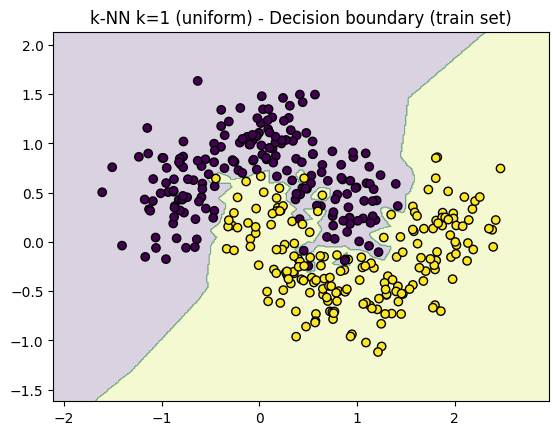

In [3]:
# --- Create a NON-LINEAR dataset ---
# "make_moons" generates a 2D dataset with two interlocking half-circles
# n_samples: number of points
# noise: added noise to make the problem more realistic
Xm, ym = make_moons(n_samples=500, noise=0.25, random_state=42)

# --- Split into training and test sets ---
# Stratify ensures the same class distribution in train and test
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, test_size=0.25, random_state=42, stratify=ym
)

# --- Function to plot the decision boundary ---
def plot_decision_boundary(pipe, X, y, title):
    """
    This function draws the decision boundary of the classifier on a grid of points.
    """
    # Define the plot boundaries (with extra margins)
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    
    # Create a grid of points (mesh) on which to evaluate the model
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Use the model to predict the class of each point on the grid
    Z = pipe.predict(grid).reshape(xx.shape)
    
    # Plotting
    plt.figure()
    # contourf colors the areas based on the predicted class
    plt.contourf(xx, yy, Z, alpha=0.2)
    # Scatter plot of the real data
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors="k")
    plt.title(title)
    plt.show()

# --- k-NN model with k=1 and uniform weights ---
# Create a Pipeline:
# 1) StandardScaler: standardizes data (mean=0, variance=1)
# 2) KNeighborsClassifier: k-NN classifier with k=1
pipe_k1 = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=1, weights="uniform"))
])

# Train the model on the training data
pipe_k1.fit(Xm_train, ym_train)

# Calculate the accuracy on the test set
acc_k1 = accuracy_score(ym_test, pipe_k1.predict(Xm_test))
print("Accuracy k=1 (uniform):", round(acc_k1, 3))

# Visualize the decision boundary on the training set
plot_decision_boundary(pipe_k1, Xm_train, ym_train, "k-NN k=1 (uniform) - Decision boundary (train set)")

Accuracy k=15 (distance): 0.944


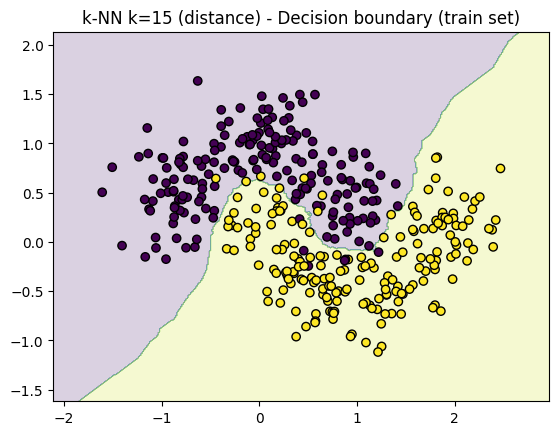

In [4]:
# --- k-NN model with k=15 and distance-based weights ---
# Create a Pipeline:
# 1) StandardScaler: standardizes features (essential for k-NN)
# 2) KNeighborsClassifier: set k=15 (considers the 15 nearest neighbors)
#    weights="distance": closer neighbors have more influence on the decision
pipe_k15 = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15, weights="distance"))
])

# Train the model on the training data
pipe_k15.fit(Xm_train, ym_train)

# Calculate accuracy on the test set
# accuracy_score compares predicted labels with the real ones
acc_k15 = accuracy_score(ym_test, pipe_k15.predict(Xm_test))
print("Accuracy k=15 (distance):", round(acc_k15, 3))

# Visualize the decision boundary on the training set
# Note: the boundary will be much smoother compared to k=1, reducing overfitting
plot_decision_boundary(pipe_k15, Xm_train, ym_train, "k-NN k=15 (distance) - Decision boundary (train set)")


## 4. Hyperparameter Tuning with **GridSearchCV**

We will search for the best combination of:
- `n_neighbors` (k)
- `weights` (`uniform` vs `distance`)
- `p` (Minkowski: 1 = Manhattan, 2 = Euclidean)

We use a **Pipeline** with `StandardScaler` to prevent data leakage during cross-validation.


In [5]:
# Create a Pipeline:
# 1) StandardScaler: standardizes features (essential for k-NN)
# 2) KNeighborsClassifier: classifier based on k-nearest neighbors
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define the parameter grid for tuning:
# - n_neighbors: number of neighbors (k)
# - weights: "uniform" (all neighbors have the same weight) or "distance" (closer -> more weight)
# - p: type of distance (1=Manhattan, 2=Euclidean)
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # p=1 -> Manhattan distance, p=2 -> Euclidean distance
}

# GridSearchCV: exhaustive search for the best parameters
# - cv=5: 5-fold cross-validation
# - n_jobs=-1: use all available CPU cores
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

# Train the model with the parameter grid
grid.fit(Xm_train, ym_train)

# Show the best parameters found
print("Best parameters:", grid.best_params_)

# Show the best average score in cross-validation
print("Best CV score:", round(grid.best_score_, 3))

# Calculate the accuracy on the test set using the optimal model
print("Accuracy on test (best):", round(grid.score(Xm_test, ym_test), 3))

Best parameters: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV score: 0.955
Accuracy on test (best): 0.944



## 5. k-NN for **Regression**

In regression, the prediction is the average (or weighted average) of the target values of the k-nearest neighbors.
- **Uniform Average**: $$\hat{y} = \frac{1}{k}\sum_{i=1}^{k} y_i$$
- **Weighted Average**: $$\hat{y} = \frac{\sum_{i=1}^{k} w_i y_i}{\sum_{i=1}^{k} w_i}, \quad \text{where } w_i = \frac{1}{d_i + \epsilon}$$

Below is an example on a noisy 1D function, comparing different values of **k**.

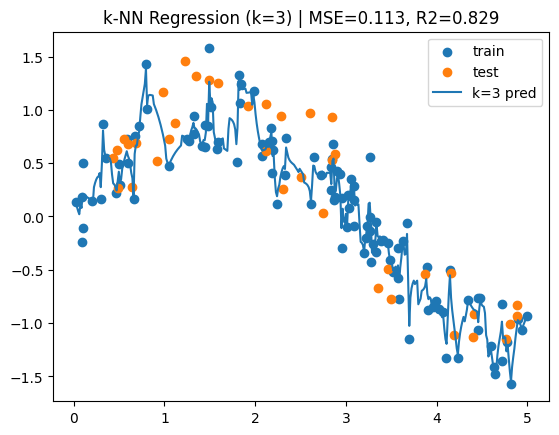

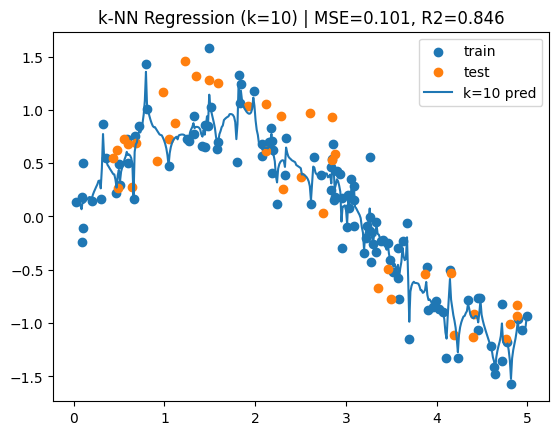

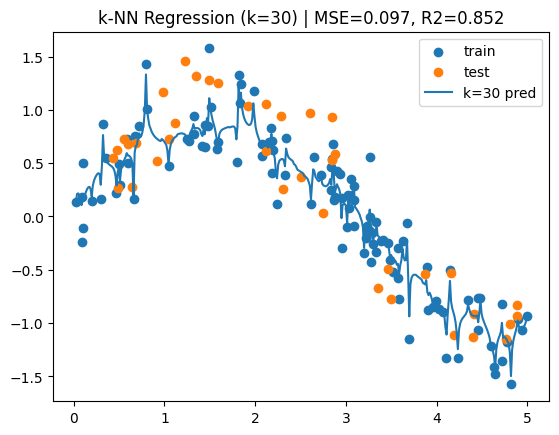

In [6]:
# Generate a synthetic dataset for regression
# - Xr: input (values from 0 to 5)
# - yr: target = sin(Xr) + noise
rng = np.random.RandomState(0)
Xr = np.sort(5 * rng.rand(150, 1), axis=0)
yr = np.sin(Xr).ravel() + 0.3 * rng.randn(150)

# Split the dataset into train and test
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=42)

# Function to train and visualize k-NN Regressor
def fit_plot_knn_reg(k, title):
    # Create the Pipeline for regression:
    # - StandardScaler: standardizes features
    # - KNeighborsRegressor: regressor based on k-nearest neighbors
    #   weights="distance": closer points have more influence on the prediction
    pipe_reg = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=k, weights="distance"))
    ])
    
    # Train the model on the training set
    pipe_reg.fit(Xr_train, yr_train)
    
    # Create a vector of points to draw the prediction curve
    x_plot = np.linspace(Xr.min(), Xr.max(), 400).reshape(-1, 1)
    y_pred_line = pipe_reg.predict(x_plot)  # prediction on the domain
    
    # Prediction on the test set to calculate metrics
    y_pred_test = pipe_reg.predict(Xr_test)
    
    # Calculate the metrics:
    # - MSE: mean squared error
    # - R2: coefficient of determination
    mse = mean_squared_error(yr_test, y_pred_test)
    r2 = r2_score(yr_test, y_pred_test)
    
    # Visualize:
    # - train/test points
    # - predicted curve
    plt.figure()
    plt.scatter(Xr_train, yr_train, label="train")
    plt.scatter(Xr_test, yr_test, label="test")
    plt.plot(x_plot, y_pred_line, label=f"k={k} pred")
    plt.legend()
    plt.title(title + f" | MSE={mse:.3f}, R2={r2:.3f}")
    plt.show()

# Test the function with 3 values of k (low, medium, high)
for k in [3, 10, 30]:
    fit_plot_knn_reg(k, f"k-NN Regression (k={k})")